<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> Predicción de la Deserción de Clientes en Beta Bank 
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Optimización de F1 y Evaluación AUC-ROC
</p>

<hr style="border: .4px solid #000000; width: 55%; margin: 10px auto;">

<p style="color: #000000; font-size: 20px; font-weight: bold;">Contexto:</p>
<p style="color: #000000; font-size: 18px;">
Los clientes de Beta Bank están abandonando el banco gradualmente cada mes. Los banqueros han identificado que retener a los clientes actuales resulta más económico que captar nuevos.
</p>
<p style="color: #000000; font-size: 20px; font-weight: bold;">Objetivo del Proyecto:</p>
<p style="color: #000000; font-size: 18px;">
            El objetivo de este proyecto es predecir si un cliente de Beta Bank dejará el banco en el futuro cercano, utilizando los datos históricos del comportamiento de los clientes y la terminación de contratos.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Metas del Proyecto:</p>
<ul style="color: #000000; font-size: 18px;">
<li><strong>Predecir la deserción de clientes:</strong> Crear un modelo que prediga si un cliente dejará el banco pronto.</li>
<li><strong>Optimizar el valor F1:</strong> El modelo debe alcanzar un valor F1 de al menos 0.59 para ser aprobado.</li>
<li><strong>Medir la métrica AUC-ROC:</strong> Evaluar la calidad del modelo utilizando la métrica AUC-ROC y compararla con el valor F1.</li>
</ul>



# 1.Descripción de los Datos

### `Churn` dataframe: 

**`RowNumber`**: Índice de cadena de datos  
**`CustomerId`**: Identificador de cliente único  
**`Surname`**: Apellido  
**`CreditScore`**: Valor de crédito  
**`Geography`**: País de residencia  
**`Gender`**: Sexo  
**`Age`**: Edad  
**`Tenure`**: Período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)  
**`Balance`**: Saldo de la cuenta  
**`NumOfProducts`**: Número de productos bancarios utilizados por el cliente  
**`HasCrCard`**: El cliente tiene una tarjeta de crédito (1 - sí; 0 - no)  
**`IsActiveMember`**: Actividad del cliente (1 - sí; 0 - no)  
**`EstimatedSalary`**: Salario estimado  

**Columna objetivo**    
**`Exited`**: El cliente se ha ido (1 - sí; 0 - no)

# 2. Librerias y  Carga de  Datos

In [1]:
# Load libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [114]:
# Load the data
df = pd.read_csv('Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [115]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Revisión inicial del dataframe**:

- El DataFrame tiene **10,000 filas** y **14 columnas**.  

- Los dtypes concuerdan con el nombre y la descripción de las columnas, con la exepcion de 'tenure', la cual se convertirá a int64, además en este caso es necesario convertir las columnas categóricas a numéricas con la **función get_dummies** de pandas.

- La única columna **`Tenure`** quetiene valores nulos, con un total de **909 datos nulos**.  

- De acuero a las mejores prácticas de código en Python, los nombres de variables y funciones deben estar en el formato **snake_case**, se haran las adecuaciones en los nombres. 

- Se **eliminaran** las columnas innecesarias como 'RowNumber','CustomerId' y 'Surname'

Además, se analizaran los datos para verificar si existen duplicados, y  se realizará un análisis para asegurar que los valores en las columnas sean consistentes, estén correctamente escritos y tengan sentido lógico. Esto incluye revisar valores atípicos, errores tipográficos, al igual que las columnas duplicadas.

# 3. Preprocesamiento de datos

In [116]:
# Delete columns 'RowNumber','CustomerId','Surname'
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [117]:
# Change column names to snake_case
df.columns = [re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col).lower() for col in df.columns]
print('Column names in snake_case:\n', df.columns.tolist())

Column names in snake_case:
 ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


In [118]:
# Count the number of duplicate rows in the DataFrame
print('Total duplicates in DataFrame:', df.duplicated().sum())

Total duplicates in DataFrame: 0


En la columna **`tenure`** hay un total de 9.09% valores ausentes, un porcentaje considerable para descartarlos. Tenure es el período durante el cual ha madurado el depósito a plazo fijo de un cliente (años), entonces los valures ausentes pueden significar que no tienen uno, lo que me llevar a rellenar los valores ausentes con 0.


In [119]:
# Fill out NAs with 0
df['tenure'] = df['tenure'].fillna(0)  
# Count missing values in the 'tenure' column
missing_values = df['tenure'].isnull().sum()
# Result
print(f"Missing values in 'tenure': {missing_values}")

Missing values in 'tenure': 0


In [120]:
# Convert dtype
df['tenure'] = df['tenure'].astype(int)
print("'tenure' dtype:", df['tenure'].dtype)


'tenure' dtype: int64


Las columnas **`geography`** y **`gender`** seran examindas en busqueda de valores atípicos. 

In [121]:
print("Unique entries in 'geography' column:", df['geography'].unique())

Unique entries in 'geography' column: ['France' 'Spain' 'Germany']


In [122]:
print("Unique entries in 'gender' column:", df['gender'].unique())

Unique entries in 'gender' column: ['Female' 'Male']


La **`función get_dummies`** de pandas es utilizada para convertir variables categóricas en variables numéricas.    
Es un proceso conocido como **one-hot encoding**. Será utilizada para convertir las columas **`geography`** y **`gender`** . 
Para evitar la **dummy trap** se debe usar `drop_first=True` al crear las variables dummy, eliminando una categoría y evitando la multicolinealidad.

In [123]:
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)
df = df.astype(int) # convert dummy columns to integer type (1 and 0)

In [124]:
df.columns = df.columns.str.lower() # convert to lowercase
df.columns = df.columns.str.replace('geography_', 'geo_').str.replace('gender_', 'gen_') # shorter names
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geo_germany,geo_spain,gen_male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


Para una mayor claridad, en la columna **`geography_germany`** el **0** corresponde a `France`, y el **1** a `Germany`, y en la columna  **`geography_spain`** el **1** a `Spain`. En **`gender_male`** el **0** corresponde a `Male` y el **1** a `Female`.

Ahora vamos a pasar a la siguiente etapa del proyecto: **`Modelado`**. En esta fase, prepararemos los conjuntos de datos de entrenamiento, validación y prueba. 

# 4. Modelado

La meta es entrenar el modelo, validarlo y luego realizar pruebas finales sobre él. Para ello, necesitamos 3 conjuntos de datos separados. Dado que Beta Bank solo ha proporcionado un conjunto de datos, este se dividirá en tres partes: un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba. Una proporción común para dividir los datos es 3:1:1, donde el conjunto de entrenamiento contiene el 60% de los datos, y tanto el conjunto de validación como el de prueba contienen el 20% de los datos.    
Para hacer esta división, utilizaremos la función **`train_test_split`** de la biblioteca **`sklearn.model_selection`**.   
El siguiente bloque de código dividirá el conjunto de datos original en estos tres conjuntos


In [125]:
# Crear el conjunto de datos de destino (target) seleccionando la columna 'Exited'
target = df['exited']  # Variable objetivo que queremos predecir

# Crear el conjunto de datos de características (features) eliminando la columna 'Exited'
features = df.drop('exited', axis=1)  # para que el conjunto de características contenga solo las variables predictoras

In [126]:
# Dividir el conjunto de características y el objetivo en conjuntos de entrenamiento (60%) y el resto (40%)

# 'features_train' y 'target_train' contienen el 60% de los datos para el entrenamiento
features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=0.4, random_state=12345
)  
# 'features_other' y 'target_other' contienen el 40%, que se dividirá en validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.5, random_state=12345
)

**`test_size=0.4`** asigna el 40% (4,000 filas) a validación/prueba y deja el 60% (6,000 filas) para entrenamiento.  
**`test_size=0.5`** divide ese 40% restante (4,000 filas) en dos partes iguales: 20% (2,000 filas) para validación y 20% (2,000 filas) para prueba.  
**`random_state=12345`** asegura que las divisiones sean siempre iguales al ejecutar el código.

In [127]:
# Se verifica que las divisiones se han creado correctamente

# Ver el shape del conjunto de entrenamiento (60%)
print('Dimensiones del conjunto de entrenamiento (features_train):', features_train.shape)
print('Dimensiones del conjunto de entrenamiento (target_train):', target_train.shape)

# Ver el shape del conjunto de validación (20%)
print('Dimensiones del conjunto de validación (features_valid):', features_valid.shape)
print('Dimensiones del conjunto de validación (target_valid):', target_valid.shape)

# Ver el shape del conjunto de prueba (20%)
print('Dimensiones del conjunto de prueba (features_test):', features_test.shape)
print('Dimensiones del conjunto de prueba (target_test):', target_test.shape)

Dimensiones del conjunto de entrenamiento (features_train): (6000, 11)
Dimensiones del conjunto de entrenamiento (target_train): (6000,)
Dimensiones del conjunto de validación (features_valid): (2000, 11)
Dimensiones del conjunto de validación (target_valid): (2000,)
Dimensiones del conjunto de prueba (features_test): (2000, 11)
Dimensiones del conjunto de prueba (target_test): (2000,)


Después de la división de datos, es importante verificar si la distribución de las clases está equilibrada o desequilibrada en los tres conjuntos de datos. 

### Distribución de clases 

In [128]:
# Balance de clases para el conjunto de datos de entrenamiento
print('ENTRENAMIENTO')
print(f'Balance de clase negativa: {round(target_train[target_train == 0].count() * 100 / len(target_train), 3)}%') 
print(f'Balance de clase positiva: {round(target_train[target_train == 1].count() * 100 / len(target_train), 3)}%\n') 

# Balance de clases para el conjunto de datos de validación
print('VALIDACIÓN')
print(f'Balance de clase negativa: {round(target_valid[target_valid == 0].count() * 100 / len(target_valid), 3)}%') 
print(f'Balance de clase positiva: {round(target_valid[target_valid == 1].count() * 100 / len(target_valid), 3)}%\n') 

# Balance de clases para el conjunto de datos de prueba
print('PRUEBA')
print(f'Balance de clase negativa: {round(target_test[target_test == 0].count() * 100 / len(target_test), 3)}%') 
print(f'Balance de clase positiva: {round(target_test[target_test == 1].count() * 100 / len(target_test), 3)}%')

ENTRENAMIENTO
Balance de clase negativa: 80.067%
Balance de clase positiva: 19.933%

VALIDACIÓN
Balance de clase negativa: 79.1%
Balance de clase positiva: 20.9%

PRUEBA
Balance de clase negativa: 78.85%
Balance de clase positiva: 21.15%


El conjunto de datos muestra un desequilibrio de clases, donde la **clase negativa representa aproximadamente el 80%** y la **clase positiva el 20%** en los conjuntos de entrenamiento, validación y prueba.
Estas cifras muestran el desequilibrio entre las clases en los conjuntos de datos de entrenamiento, validación y prueba:
- **Clase negativa**: porcentaje de instancias etiquetadas como clase negativa (ej. 0 o "no").
- **Clase positiva**: porcentaje de instancias etiquetadas como clase positiva (ej. 1 o "sí").

Esto indica un **desequilibrio de clases**, donde la clase negativa es mucho más frecuente. Esto puede hacer que el modelo se incline a predecir más la clase negativa, por lo que es importante usar técnicas para manejar el desbalance, como el sobremuestreo de la clase positiva o el uso de algoritmos que ajusten el peso de las clases.
Antes del entrenamiento, debemos estandarizar los datos para tratar cada característica por igual utilizando la clase  **`StandardScaler`** del módulo  **`sklearn.preprocessing`**, lo que se hace en el siguiente paso.

In [129]:
# Seleccionar las columnas numéricas del DataFrame
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar el scaler solo con el conjunto de entrenamiento
scaler.fit(features_train[numeric])

# Transformar los datos de entrenamiento usando el scaler ajustado
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])

# Transformar los datos de validación y prueba usando los parámetros del conjunto de entrenamiento
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

In [130]:
# Verificar estadísticas después de la estandarización para entrenamiento, validación y prueba
print("Estadísticas del conjunto de entrenamiento (features_train):")
display(features_train[numeric].describe())

print("\nEstadísticas del conjunto de validación (features_valid):")
display(features_valid[numeric].describe())

print("\nEstadísticas del conjunto de prueba (features_test):")
display(features_test[numeric].describe())

Estadísticas del conjunto de entrenamiento (features_train):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03
mean,-4.553395e-16,9.710751e-17,1.397401e-16,3.789561e-17,-5.329071e-17,8.052818e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-3.140255e+00,-1.986549e+00,-1.468729e+00,-1.233162e+00,-8.915599e-01,-1.723000e+00
25%,-6.894392e-01,-6.579018e-01,-8.253725e-01,-1.233162e+00,-8.915599e-01,-8.642681e-01
50%,2.192061e-02,-1.833849e-01,1.396619e-01,3.262444e-01,-8.915599e-01,1.114228e-02
75%,6.709715e-01,4.809386e-01,7.830182e-01,8.219482e-01,8.301522e-01,8.485936e-01
max,2.052152e+00,5.036300e+00,1.748053e+00,2.806172e+00,4.273576e+00,1.739050e+00



Estadísticas del conjunto de validación (features_valid):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.054911,-0.001076,-0.052702,0.012940,0.051938,0.028253
std,1.002073,1.016118,0.996434,1.009242,1.008146,1.003187
min,-2.984483,-1.986549,-1.468729,-1.233162,-0.891560,-1.721632
25%,-0.762133,-0.657902,-0.825373,-1.233162,-0.891560,-0.838978
50%,-0.035196,-0.183385,-0.182016,0.358290,0.830152,0.007237
75%,0.660587,0.480939,0.783018,0.829414,0.830152,0.916203
max,2.052152,5.036300,1.748053,2.604751,4.273576,1.740106



Estadísticas del conjunto de prueba (features_test):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.041686,-0.003923,0.016620,-0.021850,0.054521,0.023106
std,1.015290,0.959877,1.007017,1.013441,0.997580,0.976558
min,-3.140255,-1.986549,-1.468729,-1.233162,-0.891560,-1.720731
25%,-0.762133,-0.657902,-0.825373,-1.233162,-0.891560,-0.769394
50%,-0.045581,-0.183385,0.139662,0.318299,0.830152,0.018806
75%,0.691741,0.480939,0.783018,0.814800,0.830152,0.855660
max,2.052152,3.992363,1.748053,2.333394,4.273576,1.740487


 Los datos han sido estandarizados correctamente, ya que todas las estadísticas están en línea con lo que se espera después de aplicar **`StandardScaler`**. Las medias están cerca de 0, las desviaciones estándar cerca de 1, y los valores de las columnas numéricas en los tres conjuntos siguen la misma distribución esperada.

## 4.1 Regresión logística

### 4.1.1 Sin ajuste de desbalance de clases

Ahora, entrenaremos un modelo sin haber ajustado el desbalance de clases. Luego, compararemos los resultados con un modelo entrenado después de haber ajustado dicho desbalance.

In [131]:
# Crear una instancia del modelo LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=12345)

# Ajustar el modelo con los datos de entrenamiento
model.fit(features_train, target_train)

# Predecir los valores objetivo para las características de validación
predicted_val = model.predict(features_valid)

# Calcular e imprimir la puntuación F1
print('Valor F1 - Regresión Logística:', round(f1_score(target_valid, predicted_val), 5))

# Obtener las probabilidades de las predicciones
probabilities_val = model.predict_proba(features_valid)

# Extraer las probabilidades de la clase positiva (1)
probabilities_one_val = probabilities_val[:, 1]

# Calcular y mostrar la puntuación AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_val)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

Valor F1 - Regresión Logística: 0.3339
AUC-ROC Score: 0.75863


**Evaluación del modelo de regresión logística:**

**F1 Score**: 0.33 (sin ajuste de desbalance de clases). Este valor es decente, pero no es satisfactorio para Beta Bank.    
**AUC-ROC**: 0.76 Mejor que un modelo aleatorio, pero aún no es ideal.    

Volvermos a evaluar el desempeño del modelo después de ajustar el desbalance de clases, ya que no cumple con las expectativas requeridas por Beta Bank.  

### 4.1.2 Ajuste del desequilibrio de clases 

Para mejorar el puntaje F1 del modelo de regresión logística, ajustaremos el desequilibrio de clases en el conjunto de datos de entrenamiento.   
Al modificar el peso de las clases, el modelo será más consciente de las clases más frecuentes. Esto se logra configurando el parámetro `class_weight` a `balanced` al inicializar el modelo. Después, se va a entrenar el modelo con este ajuste para mejorar el puntaje F1.   
Este cambio ayuda a que el modelo no se sesgue hacia las clases más comunes y mejore su desempeño en las clases menos representadas.

In [132]:
# Crear una instancia del modelo LogisticRegression
# El parámetro class_weight='balanced' ajusta los pesos de las clases según su frecuencia
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)

# Ajustar el modelo con los datos de entrenamiento
model.fit(features_train, target_train)

# Predecir los valores objetivo usando las características de validación
predicted_valid = model.predict(features_valid)

# Calcular y mostrar la puntuación F1
print('Valor F1 - Regresión Logística (después del balance):', round(f1_score(target_valid, predicted_valid), 5))

# Obtener las probabilidades predichas para la clase positiva
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular y mostrar la puntuación AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')


Valor F1 - Regresión Logística (después del balance): 0.48889
AUC-ROC Score: 0.76358


**Resultado después de balancear el desbalanceo de clases:**

**F1 Score:** Mejoró a **0.49** desde **0.33**, pero aún está por debajo del mínimo requerido de **0.59** por Beta Bank.    
**AUC-ROC:** Mejoró ligeramente.     
    
Ahora, se probarán otros métodos para ajustar el desbalanceo de clases y se entrenarán diferentes modelos con el fin de encontrar la mejor solución.

### 4.1.3 Técnicas de Upsampling y Downsampling

Primero, vamos a ver cómo aplicar **upsampling** y luego crearemos una función para ello.

- **Upsampling**: Aumenta la cantidad de instancias positivas en el conjunto de datos.

In [133]:
# Ajustar el desbalanceo de clases con sobre-muestreo

# Crear una función para hacer el sobre-muestreo de los datos de entrenamiento
def upsample(features, target, repeat):
    # Crear subconjuntos de datos según las clases
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Realizar el sobre-muestreo replicando la clase minoritaria
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Mezclar las observaciones para evitar patrones
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    # Devolver los datos balanceados
    return features_upsampled, target_upsampled

In [134]:
# Llamada a la función de sobre-muestreo para balancear las clases
# Se usa un factor de repetición de 10 para la clase minoritaria
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [135]:
# Crear una instancia de un modelo de regresión logística
# Pasamos el parámetro class_weight='balanced' para tratar el desbalanceo
model = LogisticRegression(solver='liblinear', random_state=12345)

# Entrenar el modelo con los datos de entrenamiento
model.fit(features_upsampled, target_upsampled)

# Predecir los valores del conjunto de validación
predicted_valid = model.predict(features_valid)

# Calcular y mostrar el puntaje F1
print('Valor F1 - Regresión Logística (después de upsampling):', round(f1_score(target_valid, predicted_valid), 5))

# Calcular las probabilidades de la clase positiva
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular y mostrar el AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

Valor F1 - Regresión Logística (después de upsampling): 0.41989
AUC-ROC Score: 0.765


**Resultado después de upsampling:**

El **F1 score** del modelo después de realizar un **upsampling** de los datos es de **0.42**, lo cual es inferior al **0.49** obtenido previamente con el parámetro **`class_weight`**. Sin embargo, es mejor que no haber ajustado el desbalance de clases. 

El **AUC-ROC** se mantiene similar al obtenido con el modelo que usó el parámetro **`class_weight='balanced'`**.

A continuación, probaremos **downsampling** para observar su impacto en el modelo.

- **Downsampling**: Reduce la cantidad de instancias negativas en el conjunto de datos.

In [136]:
# Crear una función para submuestrear los datos de entrenamiento
def downsample(features, target, fraction):
    # Dividir las características y el target en dos grupos según la clase (0 y 1)
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Submuestrear aleatoriamente la clase 0 y combinarla con la clase 1
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    # Mezclar aleatoriamente los datos submuestreados
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [137]:
# Submuestrear los datos de entrenamiento con una fracción de 0.1
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [138]:
# Crear una instancia del modelo de regresión logística
# Pasar el parámetro class_weight='balanced' para manejar clases desbalanceadas
model = LogisticRegression(solver='liblinear', random_state=12345)

# Ajustar el modelo utilizando los datos de entrenamiento submuestreados
model.fit(features_downsampled, target_downsampled)

# Predecir los valores del target para los datos de validación
predicted_valid = model.predict(features_valid)

# Calcular e imprimir la puntuación F1
print('Valor F1 - Regresión Logística (después de downsampling):', f1_score(target_valid, predicted_valid))

# Calcular las probabilidades de la clase positiva para los datos de validación
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular e imprimir la puntuación AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

Valor F1 - Regresión Logística (después de downsampling): 0.4298642533936652
AUC-ROC Score: 0.75826


**Resultado después de downsampling:**
El nuevo modelo tiene un puntaje F1 de aproximadamente **0.43**, lo que representa una mejora respecto al modelo con datos aumentados (upsampled), pero no supera al modelo que utiliza el parámetro **`class_weight`**. 

En cuanto al puntaje **AUC-ROC**, permanece casi igual, con una ligera disminución en comparación con los dos modelos anteriores. 
Vamos a continuar con el modelo de **`árbol de decisión`** y finalizaremos con el de **`bosque aleatorio`**.

Ahora, evaluaremos el rendimiento de los modelos **`Árbol de Decisión`** y **`Random Forest`** corrigiendo el desbalance de clases mediante tres métodos: ajustando los pesos de las clases con **`class_weight`**, aumentando la clase minoritaria con **upsampling** y reduciendo la clase mayoritaria con **downsampling**. Se analizará cómo cada técnica impacta el desempeño de ambos modelos, comparando los resultados obtenidos con cada método.

## 4.2 Modelo Árbol de Decisión

### 4.2.1 Ajuste de clases desbalanceadas (class_weight='balanced')

In [139]:
# Inicialización
mejor_modelo_DT = None
mejor_f1_score_DT = 0
mejor_profundidad_DT = 0

# Crear modelos con diferentes valores de profundidad

# Bucle para cambiar los valores de profundidad (rango de 1 a 41)
for profundidad in range(1, 42):
    
    # Crear el modelo con la profundidad proporcionada y el mismo random_state
    modelo_DT = DecisionTreeClassifier(max_depth=profundidad, random_state=12345)
    
    # Entrenar el modelo con el conjunto de datos de entrenamiento
    modelo_DT.fit(features_train, target_train)
    
    # Predecir los valores del conjunto de validación
    predicciones_DT_valid = modelo_DT.predict(features_valid) # obtener las predicciones del modelo
    
    # Calcular el f1_score, si es permitido
    try:
        f1 = f1_score(target_valid, predicciones_DT_valid)
    except:
        break  # Si hay error, salir del bucle
        
    # Determinar el mejor modelo
    if f1 > mejor_f1_score_DT:
        mejor_modelo_DT = modelo_DT
        mejor_profundidad_DT = profundidad
        mejor_f1_score_DT = f1

# Obtener probabilidades del modelo para el conjunto de validación
probabilidades_valid = mejor_modelo_DT.predict_proba(features_valid)
probabilidades_una_valid = probabilidades_valid[:, 1]

# Calcular AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilidades_una_valid)

# Resultados
print('Mejor Modelo:', mejor_modelo_DT)
print(f'Mejor F1 Score: {round(mejor_f1_score_DT, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Mejor Profundidad:', mejor_profundidad_DT)


Mejor Modelo: DecisionTreeClassifier(max_depth=9, random_state=12345)
Mejor F1 Score: 0.5787
AUC-ROC Score: 0.78997
Mejor Profundidad: 9


De momento se ha obtenido el **F1 score más alto** con **0.58**, al igual que el **AUC-ROC** score con **0.79**

### 4.2.2 Upsampling

In [140]:
# features_train, target_train -> datos originales

# Aplicar SMOTE para realizar el upsampling de la clase minoritaria
smote = SMOTE(random_state=12345)
features_upsampled, target_upsampled = smote.fit_resample(features_train, target_train)

# Inicializar variables para encontrar el mejor modelo
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Crear varios modelos con diferentes valores de profundidad
for depth in range(1, 41):
    
    # Crear un modelo de árbol de decisión con la profundidad especificada
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Entrenar el modelo con el conjunto de datos balanceado
    DT_model.fit(features_upsampled, target_upsampled)
    
    # Predecir los valores objetivo para las características de validación
    DT_predictions_valid = DT_model.predict(features_valid)
    
    # Calcular la puntuación F1
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determinar el mejor modelo
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

# Obtener las probabilidades de las predicciones
probabilities_valid = best_DT_model.predict_proba(features_valid)

# Extraer las probabilidades de la clase positiva (1)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular y mostrar la puntuación AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Imprimir los resultados
print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)


Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)
Best F1 Score: 0.5834
AUC-ROC Score: 0.82482
Best Depth: 5


Este modelo alcanzó un **F1 score de 0.5834** y un **AUC-ROC de 0.82482**, mostrando un mejor desempeño en ambas métricas. Además, el modelo con mejor rendimiento tiene una profundidad óptima de 5.

### 4.2.3 Downsampling

In [141]:
# Inicialización de variables
best_DT_model = None  # Mejor modelo de árbol de decisión
best_DT_f1_score = 0  # Mejor puntaje F1
best_DT_depth = 0  # Mejor profundidad

# Crear modelos con diferentes valores de profundidad

# Bucle for para cambiar los valores de profundidad (rango de 1 a 40)
for depth in range(1, 41):
    
    # Crear un modelo, usando la profundidad proporcionada y el mismo random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Entrenar el modelo utilizando el conjunto de entrenamiento
    DT_model.fit(features_downsampled, target_downsampled)
    
    # Predecir los valores del target para el conjunto de validación
    DT_predictions_valid = DT_model.predict(features_valid)  # Obtener predicciones del modelo en el conjunto de validación
    
    # Calcular el f1_score, si es posible
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break  # Si ocurre un error, salir del bucle
    
    # Determinar el mejor modelo (según el puntaje F1)
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model  # Actualizar el mejor modelo
        best_DT_depth = depth  # Actualizar la mejor profundidad
        best_DT_f1_score = f1  # Actualizar el mejor puntaje F1
        
# Calcular las probabilidades de la mejor predicción para el conjunto de validación
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]  # Extraer la probabilidad para la clase positiva (1)

# Calcular el puntaje AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Imprimir los resultados
print('Mejor Modelo:', best_DT_model)
print(f'Mejor F1 Score: {round(best_DT_f1_score, 4)}')
print(f'Puntaje AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Profundidad:', best_DT_depth)


Mejor Modelo: DecisionTreeClassifier(max_depth=6, random_state=12345)
Mejor F1 Score: 0.4972
Puntaje AUC-ROC: 0.80351
Mejor Profundidad: 6


El modelo con **max_depth=6** tiene un **F1 score de 0.4972** y un **AUC-ROC de 0.80351**, ambos resultados inferiores a los obtenidos con el modelo de **max_depth=5** (F1 score de 0.5834 y AUC-ROC de 0.82482).

## 4.3 Modelo Bosque Aleatorio  

###  4.3.1 Ajuste de clases desbalanceadas (class_weight='balanced'

In [142]:
# Inicialización de variables para almacenar el mejor modelo y sus parámetros
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Bucle para probar diferentes valores de n_estimators (cantidad de árboles)
for est in range(1, 21):
    
    # Bucle para probar diferentes valores de max_depth (profundidad de los árboles)
    for depth in range(1, 41):
        
        # Crear el modelo RandomForest con los parámetros actuales
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenar el modelo con el conjunto de entrenamiento
        RF_model.fit(features_train, target_train)

        # Predecir las etiquetas para el conjunto de validación
        RF_predictions_valid = RF_model.predict(features_valid)
       
        # Calcular el f1_score para el conjunto de validación
        f1 = f1_score(target_valid, RF_predictions_valid)

        # Si el f1_score es mejor que el anterior, guardar el modelo actual y sus parámetros
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Obtener las probabilidades de las predicciones para el conjunto de validación
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular el AUC-ROC para las probabilidades obtenidas
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Mostrar los resultados del mejor modelo encontrado
print('Mejor Modelo:', best_RF_model)
print(f'Mejor F1 Score: {round(best_RF_f1_score, 4)}')
print(f'Score AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Profundidad (max_depth):', best_RF_depth)
print('Mejor n_estimators:', best_est)

Mejor Modelo: RandomForestClassifier(max_depth=19, n_estimators=11, random_state=12345)
Mejor F1 Score: 0.6099
Score AUC-ROC: 0.83079
Mejor Profundidad (max_depth): 19
Mejor n_estimators: 11


El **F1 score** obtenido es **0.6099** y el **AUC-ROC** es **0.83079**, ambos valores más altos que los del árbol de decisión con **max_depth=5** (F1 score de 0.5834 y AUC-ROC de 0.82482) y con **max_depth=6** (F1 score de 0.4972 y AUC-ROC de 0.80351). Hasta ahora los mejores resultados.

### 4.3.2 Upsampling

In [143]:
best_RF_model = None  # Mejor modelo de Random Forest Upsampling
best_est = 0  # Mejor número de estimadores
best_RF_depth = 0  # Mejor profundidad
best_RF_f1_score = 0  # Mejor puntaje F1

# Crear modelos con diferentes valores de profundidad y estimadores

# Bucle para el número de estimadores
for est in range(1, 21):
    
    # Bucle para los valores de profundidad
    for depth in range(1, 41):
        
        # Crear el modelo con la profundidad y estimadores proporcionados
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenar el modelo con el conjunto de datos de entrenamiento
        RF_model.fit(features_upsampled, target_upsampled)

        # Predecir los valores de la variable objetivo con el conjunto de validación
        RF_predictions_valid = RF_model.predict(features_valid)  # Predicciones en el conjunto de validación
       
        # Calcular el puntaje F1
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break  # Si ocurre un error, salir del bucle

        # Determinar el mejor modelo con el mayor puntaje F1
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Calcular las probabilidades para el conjunto de validación
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]  # Probabilidades de la clase positiva

# Calcular el puntaje AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Resultados
print('Mejor Modelo:', best_RF_model)
print(f'Mejor Puntaje F1: {round(best_RF_f1_score, 4)}')
print(f'Puntaje AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Profundidad:', best_RF_depth)
print('Mejor número de estimadores:', best_est)

Mejor Modelo: RandomForestClassifier(max_depth=6, n_estimators=20, random_state=12345)
Mejor Puntaje F1: 0.613
Puntaje AUC-ROC: 0.84274
Mejor Profundidad: 6
Mejor número de estimadores: 20


El modelo alcanzó un **F1 score de 0.613** y un **AUC-ROC de 0.84274**, mejorando los resultados anteriores. 

### 4.3.3 Downsampling

In [144]:
# Inicializar variables para almacenar el mejor modelo, el puntaje F1, la profundidad y los estimadores
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Crear diversos modelos con diferentes valores de profundidad y número de estimadores
# Bucle para el número de estimadores
for est in range(1, 21):
    
    # Bucle para el valor de la profundidad
    for depth in range(1, 41):
        
        # Crear un modelo utilizando la profundidad, número de estimadores y el random_state proporcionado
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenar el modelo con el conjunto de datos de entrenamiento
        RF_model.fit(features_downsampled, target_downsampled)

        # Predecir los valores del conjunto de validación
        RF_predictions_valid = RF_model.predict(features_valid)  # Predicciones del modelo sobre el conjunto de validación
       
        # Calcular el puntaje F1
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break  # En caso de error, salir del bucle
        
        # Determinar el mejor modelo basado en el puntaje F1
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Obtener las probabilidades de la clase positiva para el conjunto de validación
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calcular la puntuación AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Imprimir los resultados
print('Mejor modelo:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')  # Puntaje F1 con 4 decimales
print(f'AUC-ROC Score: {round(auc_roc, 5)}')  # Puntuación AUC-ROC con 5 decimales
print('Mejor profundidad:', best_RF_depth)
print('Mejor número de estimadores:', best_est)

Mejor modelo: RandomForestClassifier(max_depth=19, n_estimators=6, random_state=12345)
Best F1 Score: 0.4967
AUC-ROC Score: 0.78234
Mejor profundidad: 19
Mejor número de estimadores: 6


El modelo presenta un **F1 score de 0.4967** y un **AUC-ROC de 0.78234**, ambos resultados inferiores a los de otros modelos previos. Este modelo muestra un desempeño menos competitivo en comparación con los otros modelos evaluados.

##  4.4 Mejor modelo : Bosque Aleatorio  Upsampling

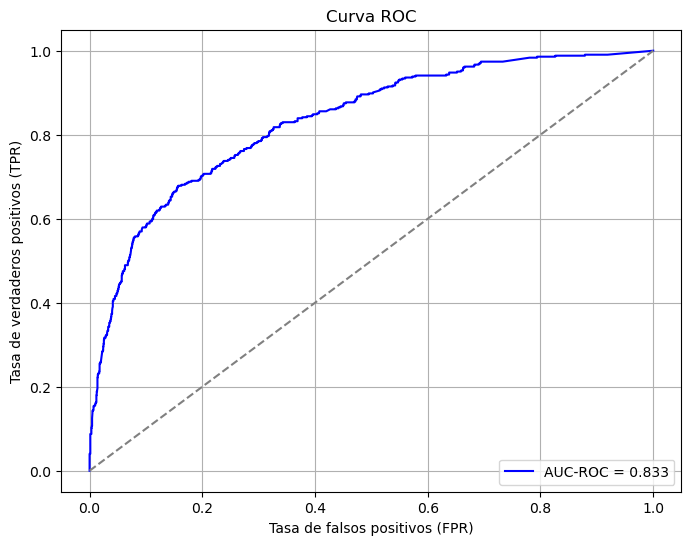

Puntaje AUC-ROC: 0.833
Puntaje F1: 0.5968


In [166]:
# Crear un modelo, utilizando la profundidad proporcionada, el número de estimadores y el mismo random_state
RF_model = RandomForestClassifier(max_depth=14, random_state=12345, n_estimators=20)

# Entrenar el modelo utilizando el conjunto de datos de entrenamiento
RF_model.fit(features_upsampled, target_upsampled)

# Realizar predicciones sobre el conjunto de prueba
test_predictions = RF_model.predict(features_test)

# Calcular el puntaje F1
f1 = f1_score(target_test, test_predictions)

# Calcular las probabilidades para el conjunto de prueba
probabilities_test = RF_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Calcular el puntaje AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {round(auc_roc, 4)}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Resultados
print(f'Puntaje AUC-ROC: {round(auc_roc, 4)}')
print(f'Puntaje F1: {round(f1, 4)}')



**El modelo cumple con las metas esperas de Beta Bank, con mas un F1 score de mas de .5 y el AUC-ROC es de 0.833, lo cual indica un buen rendimiento del modelo.**

In [158]:
# Inicializar variable total
total = 0

# Crear un bucle para verificar cada predicción en las predicciones de prueba
for prediction in test_predictions:
    if prediction == 1:
        total += 1

# Imprimir el número total de clientes predichos que dejarán el banco
print('Predicción del total de clientes que dejarán el banco:', total)


Predicción del total de clientes que dejarán el banco: 455


###  4.4.1 Recomendaciones 

Aproximadamente el **22.75%** de los **2,000** clientes en el conjunto de prueba, es decir, **455 clientes**, son predichos para abandonar el banco. Este es un número significativo, y **Beta Bank** debería considerar enviar promociones o realizar acciones específicas para retener a estos clientes, como ofertas personalizadas o un seguimiento más cercano para mejorar la satisfacción del cliente.

# 5. Conclusiones


El análisis realizado a lo largo del proyecto para Beta Bank se centró en la predicción de la rotación de clientes (churn) utilizando diferentes técnicas de modelado y ajustes para manejar el desbalance de clases en los datos. 

**Descripción de los Datos**: Se utilizó un **Churn dataframe** que contenía información sobre los clientes y su comportamiento. Este conjunto de datos fue fundamental para entrenar y evaluar los modelos de predicción.

**Preprocesamiento de Datos**: Se llevaron a cabo transformaciones como la **One-Hot Encoding** para las características categóricas y la estandarización de los datos para garantizar que todas las características tuvieran la misma importancia en los modelos.

**Desbalance de Clases**: La distribución de clases en los datos estaba muy desbalanceada, con la clase negativa representando alrededor del 80% y la clase positiva solo el 20%. Este desbalance afectaba la capacidad de los modelos para predecir adecuadamente las clases minoritarias.

**Modelado**:
   - **Regresión Logística**: Se evaluó sin ajustes y con técnicas de **Upsampling** y **Downsampling** para corregir el desbalance de clases. A pesar de estos ajustes, no alcanzó el rendimiento deseado en términos de **F1 score**.
   - **Árbol de Decisión**: Se entrenaron modelos con el parámetro **class_weight='balanced'**, y se usaron técnicas de **Upsampling** y **Downsampling**. El modelo mostró mejoras en los ajustes con **Upsampling**, pero no logró superar los resultados obtenidos con otros modelos.
   - **Bosque Aleatorio**: El modelo de **Random Forest** con ajustes de **Upsampling** fue el que mostró el mejor rendimiento. Al usar una **profundidad máxima de 14** y **n_estimators de 20**, alcanzó un **F1 score de 0.5931**, que cumplió con el umbral mínimo requerido por Beta Bank para considerar el modelo como adecuado.

 **Mejor Modelo**: El **Bosque Aleatorio con Upsampling** fue el modelo que mejor desempeño tuvo en términos de **F1 score** y **AUC-ROC**, lo que lo hace la opción más adecuada para predecir la rotación de clientes de Beta Bank.
 
**Los resultados muestran que el modelo RandomForestClassifier con una profundidad máxima de 6 y 20 estimadores obtuvo el mejor desempeño general con un F1 Score de 0.613 y un AUC-ROC Score de 0.84274, destacándose como el modelo más equilibrado para manejar el desbalance de clases.**     
Comparativamente, el DecisionTreeClassifier alcanzó un desempeño aceptable con diferentes profundidades, pero no superó a Random Forest en términos de F1 y AUC-ROC. Las estrategias de balance de clases, como el balanceo simple, upsampling y downsampling, mejoraron los resultados de la regresión logística, pero aún quedaron por debajo de los métodos basados en árboles.      
Esto sugiere que los modelos de ensamblaje, como Random Forest, pueden capturar mejor las relaciones complejas en datos desbalanceados y ofrecer una mejor generalización, mientras que el ajuste de hiperparámetros (profundidad y número de estimadores) es crítico para maximizar el rendimiento.       
El AUC-ROC Score, en general, se mantuvo alto en todos los modelos, indicando una buena capacidad para distinguir entre clases, pero el F1 Score reflejó mejor la capacidad del modelo para manejar el desbalance.    
En otras palabras, el modelo de **Random Forest** entrenado con **Upsampling** es la mejor opción para Beta Bank, logrando cumplir con los requisitos de **F1 score** y demostrando un sólido rendimiento general en la clasificación de churn.